In [1]:
import os
import random
import shutil
import warnings
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
def Load_Train_data(path='../data/train/AECG_Train.mat'):
    train_data = loadmat(path)
    train_df = pd.DataFrame({'id':[i for i in range(1,77)]})
    labels = [i for j in range(19) for i in range(1, 5)]
    user_id = sum([[i]*4 for i in range(1,20)],[])
    train_df['user_id'] = user_id
    signals = []
    for i in range(19):
        for j in range(4):
            signals.append(train_data['DataTrain'][0][0][0][i][j].reshape((-1,)))
    train_df['signal'] = signals
    train_df['label'] = labels
    return train_df

def Load_Test_data(path='../data/test/Data.mat'):
    test_data = loadmat(path)
    test_df = pd.DataFrame({'id':[i for i in range(1, test_data['Data'][0][0][0].shape[0]+1)]})
    signals = []
    for i in range(test_df.shape[0]):
        signals.append(test_data['Data'][0][0][0][i][0][0])
    test_df['signal'] = signals
    test_df['label'] = -1
    return test_df

In [4]:
def enhanced_train_df(train_df, col_name, step=320):
    indices = np.arange(0, 15040, step)
    ids = [str(id)+'_%i'%i for id in train_df.id for i in range(indices.shape[0])]
    seqs = train_df[col_name].apply(lambda x:[x[i:i+320] for i in indices]).tolist()
    flat_seqs = sum(seqs, [])
    labels = sum([[l-1]*indices.shape[0] for l in train_df.label],[])
    new_df = pd.DataFrame({'id':ids, col_name:flat_seqs, 'label':labels})
    return new_df

In [5]:
# Load train test data
train_df = Load_Train_data()
test_df = Load_Test_data()

In [6]:
train_df.head(3)

,id,user_id,signal,label
0,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 3.22, 4.83...",1
1,2,1,"[28.27, 27.76, 22.09, 21.17, 24.05, 27.64, 31....",2
2,3,1,"[0.0, 0.0, 0.0, 0.0, 1.2, 0.0, 0.0, 0.51, 2.1,...",3


# 数据增强

In [7]:
# 切片增强
en_train_df = enhanced_train_df(train_df, 'signal', 320)

all_df = en_train_df.append(test_df)

In [8]:
# 归一化
all_df['norm_signal'] = all_df.signal.apply(lambda x: mean_scale(x))
# 不做归一化,不降噪
all_df['input_signal'] = all_df.signal.apply(lambda x: x.reshape(320, 1))

# 移动平滑降噪signal
ws = np.ones(6)/6.
all_df['ma6_signal'] = all_df.signal.apply(lambda x: np.convolve(ws,x)[:-5].reshape(320, 1))
# 归一化降噪
#all_df['ma6_normal'] = all_df.norm_signal.apply(lambda x: np.convolve(ws, x)[:-5].reshape(320, 1))

#all_df['spectrogram'] = all_df.signal.apply(lambda x: signal.spectrogram(x, 64)[-1])

# 功率谱密度PSD
#all_df['welch'] = all_df.signal.apply(lambda x: signal.welch(x, 64)[-1].reshape(129, 1))

In [11]:
all_df.head(3)

,id,signal,label,norm_signal,input_signal,ma6_signal
0,1_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 3.22, 4.83...",0,"[-27.496968749999997, -27.496968749999997, -27...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1,1_1,"[98.27, 99.37, 99.98, 99.98, 99.98, 99.98, 94....",0,"[68.46587499999998, 69.565875, 70.175874999999...","[[98.27], [99.37], [99.98], [99.98], [99.98], ...","[[16.37833333333333], [32.94], [49.60333333333..."
2,1_2,"[99.98, 99.98, 99.98, 99.98, 95.53, 81.62, 60....",0,"[69.63021875000001, 69.63021875000001, 69.6302...","[[99.98], [99.98], [99.98], [99.98], [95.53], ...","[[16.663333333333334], [33.32666666666667], [4..."


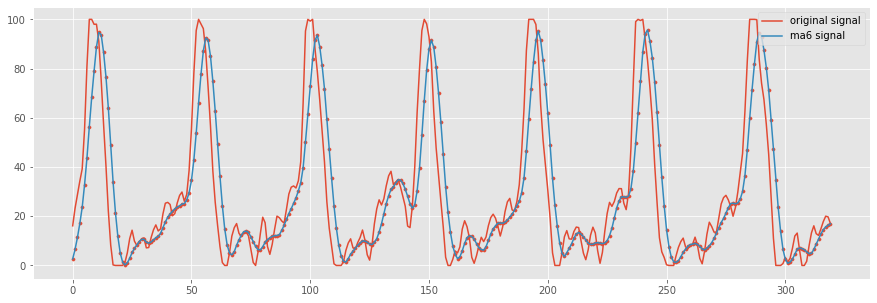

In [12]:
xo = all_df.iloc[100, 1]
xma = all_df.iloc[100, -1]
plt.figure(figsize=(15, 5))
plt.plot(xo, label='original signal')
plt.plot(xma, label='ma6 signal')
plt.scatter(range(xma.shape[0]), xma, s=10)
plt.legend()

### signal processing

......

## CNN : Ecgnet

In [13]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization,Permute,LSTM, Reshape, RepeatVector
from keras.layers import Conv1D, MaxPooling1D, ReLU, AveragePooling1D, Concatenate,Multiply
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold, train_test_split

Using TensorFlow backend.


In [14]:
def attention_block(inputs, share_weights=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps, input_dim = int(inputs.shape[-2]), int(inputs.shape[-1])
    a = Reshape((input_dim, time_steps))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if share_weights:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Reshape((time_steps, input_dim))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [15]:
def ECGnet(input_shape=(320, 1)):
    inputs = Input(input_shape)
    sub_h1 = Conv1D(filters=16, kernel_size=11, strides=1, padding='same')(inputs)
    sub_h1 = BatchNormalization()(sub_h1)
    sub_h1 = ReLU()(sub_h1)
    sub_h1 = Conv1D(filters=64, kernel_size=11, strides=2, padding='same')(sub_h1)
    sub_h1 = BatchNormalization()(sub_h1)
    sub_h1 = ReLU()(sub_h1)
    sub_h1 = Conv1D(filters=64, kernel_size=11, strides=2, padding='same')(sub_h1)
    sub_h1 = BatchNormalization()(sub_h1)
    sub_h1 = ReLU()(sub_h1)
    #sub_h1 = attention_block(sub_h1)
    sub_h1 = AveragePooling1D(5)(sub_h1)
    sub_h1 = MaxPooling1D(4)(sub_h1)
    sub_h1 = Flatten()(sub_h1)
    sub_h1 = Dropout(0.25)(sub_h1)
    sub_h1 = Dense(256)(sub_h1)
    sub_h1 = BatchNormalization()(sub_h1)
    sub_h1 = ReLU()(sub_h1)
    sub_h1 = Dropout(0.25)(sub_h1)
    outputs = Dense(4, activation='softmax')(sub_h1)
    model = Model(inputs = inputs, outputs = outputs)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                            decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
    return model

In [16]:
def plot_LearnCurve(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss Curve')
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Valid')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.title('Acc Curve')
    plt.plot(history.history['acc'], label='Train')
    plt.plot(history.history['val_acc'], label='Valid')
    plt.grid(True)

In [17]:
en_train_df.shape, test_df.shape

((3572, 3), (2162, 3))

In [18]:
train_data = np.array(all_df['ma6_signal'].iloc[:3572].tolist())
test_data = np.array(all_df['ma6_signal'].iloc[3572:].tolist())
labels = en_train_df.label

In [19]:
train_data.shape

(3572, 320, 1)

In [20]:
#train_x, valid_x, train_y, valid_y = train_test_split(train_data, labels, test_size=0.25, random_state=2020)

train_indices, valid_indices, train_y, valid_y = train_test_split(np.arange(train_data.shape[0]).reshape(-1,1),
                                                                  labels, test_size=0.25, random_state=2020)

train_indices = train_indices.reshape(1, -1)[0]
valid_indices = valid_indices.reshape(1, -1)[0]

train_x = train_data[train_indices]
valid_x = train_data[valid_indices]

y_train = keras.utils.to_categorical(train_y, num_classes=4)
y_valid = keras.utils.to_categorical(valid_y, num_classes=4)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [22]:
model = ECGnet((320, 1))
history = model.fit(train_x, y_train, batch_size=96, epochs=120,validation_data=(valid_x, y_valid), callbacks=[lr_reduce])




Train on 2679 samples, validate on 893 samples
Epoch 1/120
2679/2679 [==============================] - 8s 3ms/step - loss: 1.6094 - acc: 0.2602 - val_loss: 2.4397 - val_acc: 0.2576
Epoch 2/120
2679/2679 [==============================] - 0s 147us/step - loss: 1.5320 - acc: 0.2647 - val_loss: 1.8403 - val_acc: 0.2576
Epoch 3/120
2679/2679 [==============================] - 0s 134us/step - loss: 1.4973 - acc: 0.2605 - val_loss: 1.4243 - val_acc: 0.2710
Epoch 4/120
2679/2679 [==============================] - 0s 143us/step - loss: 1.4534 - acc: 0.2863 - val_loss: 1.4376 - val_acc: 0.2620
Epoch 5/120
2679/2679 [==============================] - 0s 138us/step - loss: 1.4426 - acc: 0.2848 - val_loss: 1.4771 - val_acc: 0.2844
Epoch 6/120
2679/2679 [==============================] - 0s 141us/step - loss: 1.4022 - acc: 0.3285 - val_loss: 1.4027 - val_acc: 0.2688
Epoch 7/120
2679/2679 [==============================] - 0s 145us/step - loss: 1.3888 - acc: 0.3255 - val_loss: 1.4239 - val_acc: 

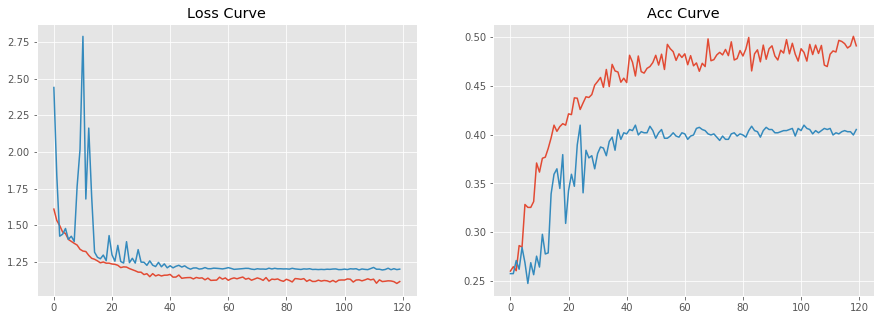

In [23]:
plot_LearnCurve(history)   # ma6_signal

# make submit

1. submit_ma5.csv  : 0.34559
2. submit_ma3.csv  : 0.31235
3. submit_att2.csv : 0.30143
4. submit_ma6.csv : 0.3645

In [102]:
pre = model.predict(test_data)

In [103]:
submit = pd.read_csv('../data/example.csv')
submit.label = np.argmax(pre, axis=1)+1
submit.to_csv('../submit/submit_sub3ma6_signal.csv',index=False)   # att2 add attention on subh1

In [37]:
submit

,id,label
0,1,1
1,2,1
2,3,1
3,4,4
4,5,4
...,...,...
2157,2158,2
2158,2159,4
2159,2160,3
2160,2161,2


### 模型可视化

In [104]:
from keras.utils.vis_utils import plot_model

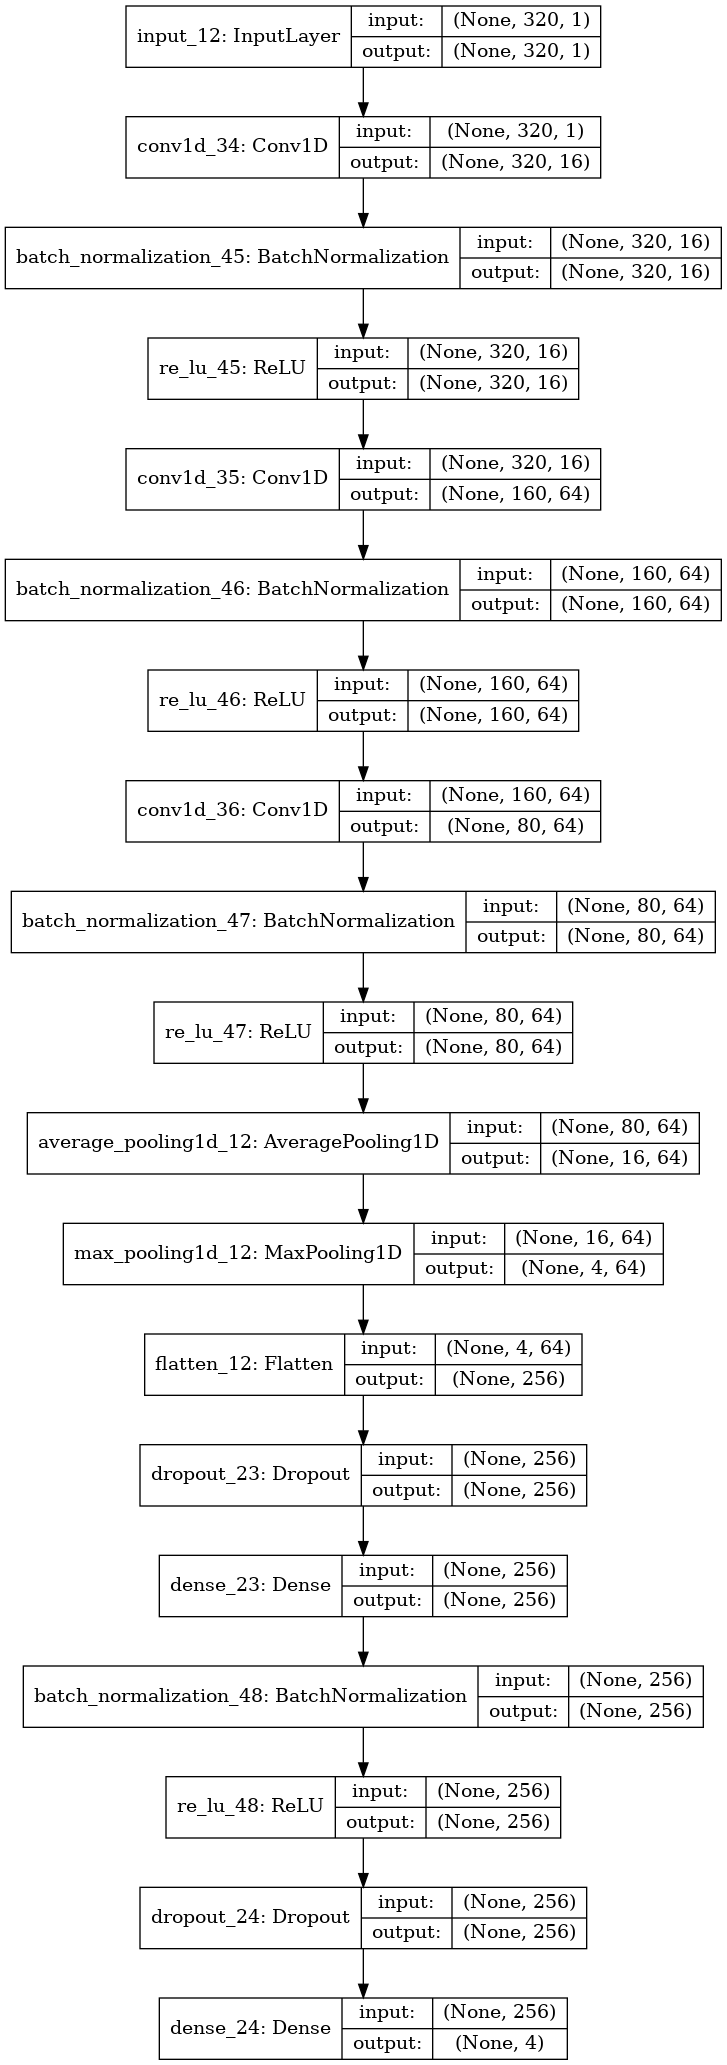

In [105]:
plot_model(model, to_file='../model/ECGnet.png', show_shapes=True, show_layer_names=True)

### 特征敏感性分析

我们应该使⽤模型没有见过的测试(验证)数据,基于训练数据的特征重要性会使我们错误地认为某些噪声特征对于预测很重要，⽽实际上模型只是过拟合训练集⽽特征根本不重要。

In [106]:
data = all_df.query('label != -1')

,id,signal,label,norm_signal,input_signal,ma6_signal,ma6_normal
0,1_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 3.22, 4.83...",0,"[-0.27502469243848765, -0.27502469243848765, -...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[-0.04583744873974794], [-0.09167489747949588..."
1,1_1,"[98.27, 99.37, 99.98, 99.98, 99.98, 99.98, 94....",0,"[0.6847957091418282, 0.6957979095819165, 0.701...","[[98.27], [99.37], [99.98], [99.98], [99.98], ...","[[16.37833333333333], [32.94], [49.60333333333...","[[0.1141326181903047], [0.23009893645395743], ..."
2,1_2,"[99.98, 99.98, 99.98, 99.98, 95.53, 81.62, 60....",0,"[0.6964414757951591, 0.6964414757951591, 0.696...","[[99.98], [99.98], [99.98], [99.98], [95.53], ...","[[16.663333333333334], [33.32666666666667], [4...","[[0.11607357929919318], [0.23214715859838636],..."


In [115]:
ma_array = np.array(data['ma6_signal'].tolist())
data['pred'] = np.argmax(model.predict(ma_array), axis=1)
print(classification_report(data.label, data.pred))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       893
           1       0.46      0.46      0.46       893
           2       0.54      0.48      0.51       893
           3       0.57      0.49      0.53       893

    accuracy                           0.54      3572
   macro avg       0.54      0.54      0.53      3572
weighted avg       0.54      0.54      0.53      3572



#### 只过滤出分类正确的样本

In [111]:
correct_data = data[data.label == data.pred]

In [112]:
correct_data.label.value_counts()

0    643
3    434
2    428
1    413
Name: label, dtype: int64

## 1. 特征置换
1. 25

In [116]:
np.arange(0, 295, 10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290])

In [114]:
np.array(correct_data.query('label == 0')['ma6_signal'].tolist())

(643, 320, 1)

In [163]:
np.random.randint(0, 99,size=(2,2))

array([[36, 70],
       [ 1, 90]])

In [177]:
data_0 = []
data_1 = []
data_2 = []
data_3 = []
for i in np.arange(0, 320, 11):
    array_0 = np.array(correct_data.query('label == 0')['ma6_signal'].tolist())
    array_1 = np.array(correct_data.query('label == 1')['ma6_signal'].tolist())
    array_2 = np.array(correct_data.query('label == 2')['ma6_signal'].tolist())
    array_3 = np.array(correct_data.query('label == 3')['ma6_signal'].tolist())
    # 随机噪声取代0擦除
    array_0[:, i:i+11] = 0
    array_1[:, i:i+11] = 0
    array_2[:, i:i+11] = 0
    array_3[:, i:i+11] = 0
    data_0.append(array_0.reshape(-1, 320, 1))
    data_1.append(array_1.reshape(-1, 320, 1))
    data_2.append(array_2.reshape(-1, 320, 1))
    data_3.append(array_3.reshape(-1, 320, 1))

In [179]:
e0_acc = []
for temp_input, i in zip(data_0, np.arange(0, 320,11 )):
    pred = np.argmax(model.predict(temp_input), axis=1)
    accuracy = np.mean(pred == 0)
    e0_acc.append(accuracy)

e1_acc = []
for temp_input, i in zip(data_1, np.arange(0, 320,11 )):
    pred = np.argmax(model.predict(temp_input), axis=1)
    accuracy = np.mean(pred == 1)
    e1_acc.append(accuracy)

e2_acc = []
for temp_input, i in zip(data_2, np.arange(0, 320,11 )):
    pred = np.argmax(model.predict(temp_input), axis=1)
    accuracy = np.mean(pred == 2)
    e2_acc.append(accuracy)

e3_acc = []
for temp_input, i in zip(data_3, np.arange(0, 320,11 )):
    pred = np.argmax(model.predict(temp_input), axis=1)
    accuracy = np.mean(pred == 3)
    e3_acc.append(accuracy)

In [180]:
np.arange(0, 320, 20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300])

Text(0.5, 1.0, 'E3')

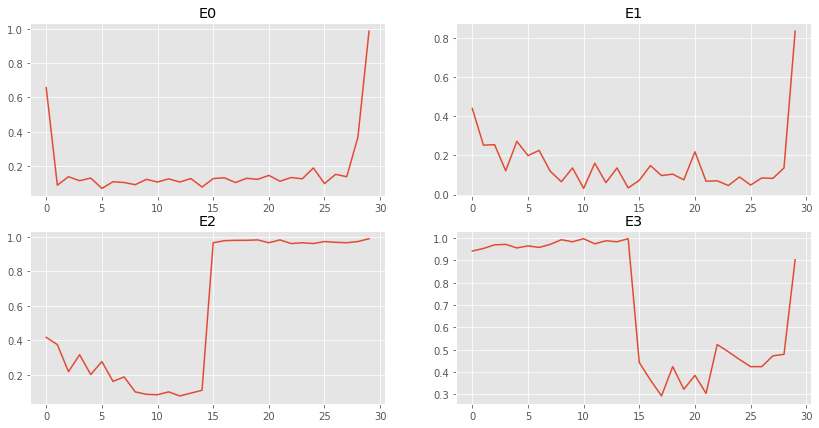

In [181]:
# 平和,伤心,愤怒,开心
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.plot(e0_acc)
#plt.axhline(0.69, c='blue')
plt.title("E0")
plt.subplot(2, 2, 2)
plt.plot(e1_acc)
#plt.axhline(0.35, c='blue')
plt.title("E1")
plt.subplot(2, 2, 3)
plt.plot(e2_acc)
#plt.axhline(0.45, c='blue')
plt.title("E2")
plt.subplot(2, 2, 4)
plt.plot(e3_acc)
#plt.axhline(0.45, c='blue')
plt.title("E3")

## original signal


In [122]:
df_0 = correct_data.query('label == 0')
df_1 = correct_data.query('label == 1')
df_2 = correct_data.query('label == 2')
df_3 = correct_data.query('label == 3')

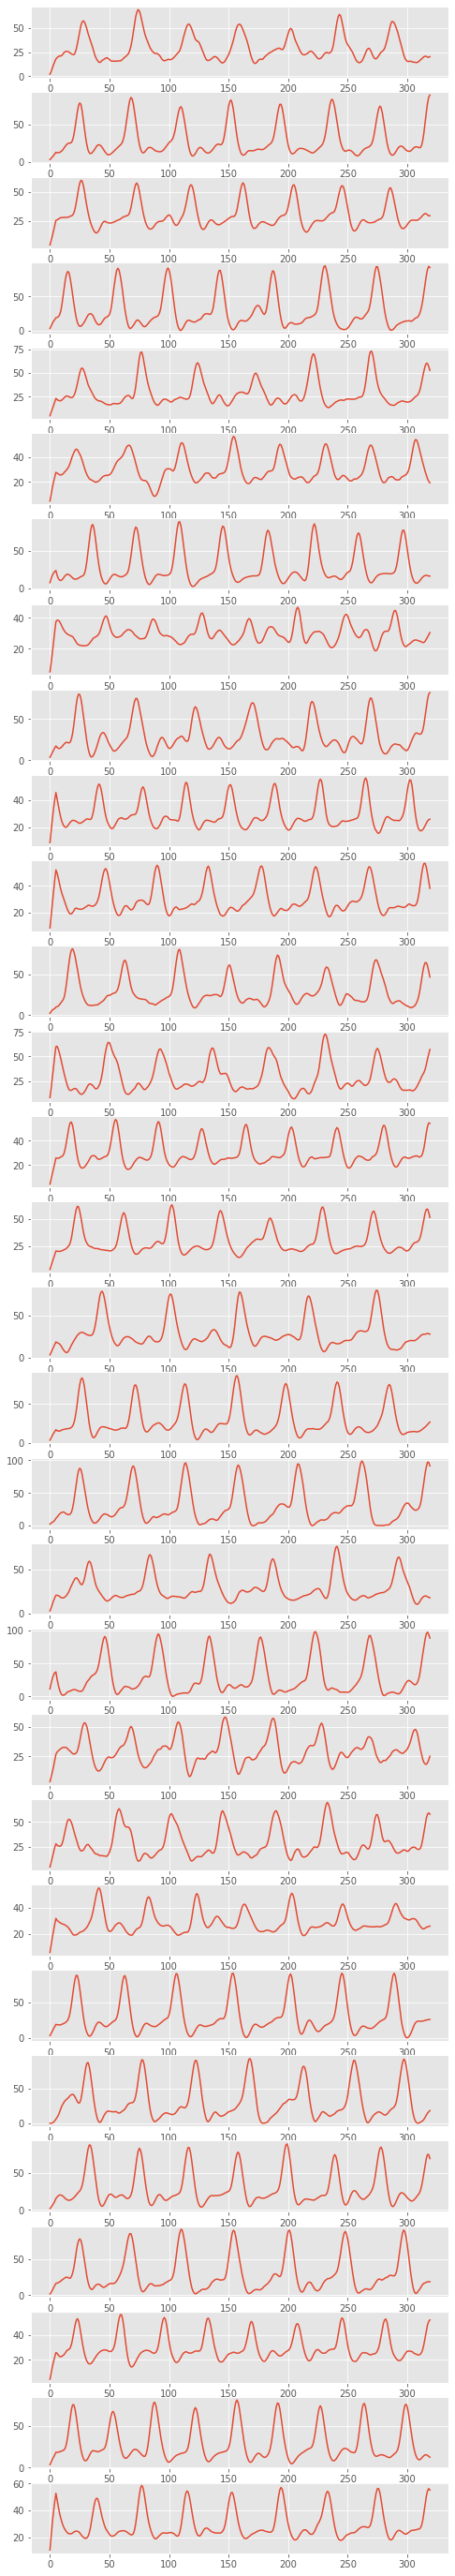

In [172]:
plt.figure(figsize=(8,50))
temp_df = df_2.sample(n=30)
for i in range(30):
    plt.subplot(30,1, i+1)
    plt.plot(temp_df['ma6_signal'].iloc[i])
    #plt.axvline(180, c='black')
    #plt.axvline(180+20, c='black')
    #plt.axvline(160+50, c='black')
    #plt.axvline(160+75, c='black')
    #plt.axvline(160+100, c='black')

## 2. 全局代理模型

全局代理模型是⼀种可解释的模型，经过训练可近似于⿊盒模型的预测。我们可以通过解释代理模 型得出有关⿊盒模型的结论。